Part 1: Libraies import, lib comaptibility check with qiskit, cpu/gpu, drive connect

In [ ]:
!pip install qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 19.1 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Tue Sep  9 14:25:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# !pip install qiskit qiskit-aer

In [ ]:
 !pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Part 2: reading diagnosis file and label encoding diagnosis

In [ ]:
# Read CSV and encode labels
csv_file = "/content/drive/MyDrive/input_files/patient_diagnosis.csv"
df = pd.read_csv(csv_file, header=None)
df.columns = ['p_no', 'diagnosis']
label_encoder = LabelEncoder()
df['encoded_diagnosis'] = label_encoder.fit_transform(df['diagnosis'])



Part 3: image loading class
and image transformation

In [ ]:
# Custom Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, image_folder,label, dataframe, transform=None):
        self.label = label
        self.image_paths = glob.glob(os.path.join(image_folder, "*.png"))
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
       # patient_id = int(os.path.basename(img_path).split("_")[0])
       # label = self.df[self.df['p_no'] == patient_id]['encoded_diagnosis'].values[0]'''

        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, self.label

checkpoint

In [ ]:
# Define image transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),       # Resize to match CNN input (or your target)
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Part 4: images loading from drive

In [ ]:
full_dataset = []

Chronic

In [ ]:
image_folder = "/content/drive/MyDrive/augmented_spectrograms/COPD"
help = SpectrogramDataset(image_folder=image_folder, label=0, dataframe=df, transform=transform)

full_dataset.extend(help)

len(help), type(help), len(full_dataset)

(793, __main__.SpectrogramDataset, 793)

Healthy

In [ ]:
image_folder = "/content/drive/MyDrive/augmented_spectrograms/Healthy"
help = SpectrogramDataset(image_folder=image_folder, label=1, dataframe=df, transform=transform)

full_dataset.extend(help)

len(help), type(help), len(full_dataset)

(952, __main__.SpectrogramDataset, 1745)

Non- Chronic

In [ ]:
image_folder = "/content/drive/MyDrive/augmented_spectrograms/Pneumonia"
help = SpectrogramDataset(image_folder=image_folder, label=2, dataframe=df, transform=transform)

full_dataset.extend(help)

len(help), type(help), len(full_dataset)

(1028, __main__.SpectrogramDataset, 2773)

In [ ]:
full_dataset[0]

(tensor([[[-0.1922, -0.8039, -0.8902,  ..., -0.8902, -0.8510, -0.5373],
          [-0.1922, -0.8039, -0.8902,  ..., -0.8902, -0.8510, -0.5216],
          [-0.1922, -0.8039, -0.8902,  ..., -0.8902, -0.8510, -0.5216],
          ...,
          [ 0.6863,  0.6549,  0.5529,  ...,  0.4588,  0.3333,  0.5451],
          [ 0.6627,  0.5451,  0.2863,  ...,  0.6235,  0.6000,  0.6078],
          [ 0.2549, -0.0196, -0.3725,  ...,  0.2863,  0.3176,  0.4588]]]),
 0)

Part 5: image dataset splitting and loaders

In [ ]:
# Train-test split (e.g., 80-20)
train_size = int(0.70 * len(full_dataset))
# val_size = int(0.25*len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size
test_size = len(full_dataset) - train_size

# train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size,test_size])
train_dataset,test_dataset = torch.utils.data.random_split(full_dataset, [train_size,test_size])
print(f"Train size: {len(train_dataset)}")
# print(f"Validation size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1941
Test size: 832


batch size, train-test-valid size, epochs

In [ ]:
# DataLoaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_dataset[0]

(tensor([[[-0.5294, -0.7020, -0.8118,  ..., -0.8667, -0.8824, -0.8039],
          [-0.4902, -0.6941, -0.8118,  ..., -0.8667, -0.8745, -0.8039],
          [-0.3412, -0.6471, -0.7882,  ..., -0.8275, -0.6549, -0.5059],
          ...,
          [ 0.5765,  0.5294,  0.4431,  ...,  0.5059,  0.5843,  0.6235],
          [ 0.5922,  0.5216,  0.6157,  ...,  0.6471,  0.6392,  0.6471],
          [-0.0039, -0.1373,  0.0118,  ...,  0.1451,  0.0667,  0.0980]]]),
 2)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# images, labels = next(iter(trainloader))
# print(images.shape)  # Output: torch.Size([32, 4, 4, 4])  -> 32 images, 4 channel, 4x4 size
# print(labels[:5])    # Print first 5 labels
# n_img = 3
# # Function to display RGBA images
# def show_images(images, labels):
#     fig, axes = plt.subplots(1, n_img, figsize=(12, 3))
#     for i in range(n_img):
#         img = images[i].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
#         if img.shape[2] == 4:  # Drop alpha channel if present
#             img = img[:, :, :3]
#         img = (img * 0.5) + 0.5  # De-normalize (from [-1, 1] to [0, 1])
#         axes[i].imshow(img)
#         axes[i].set_title(f'Label: {labels[i].item()}')
#         axes[i].axis('off')
#     plt.tight_layout()
#     plt.show()

# show_images(images, labels)


Part 6: configuration and search space

No of qubits, optimal design of quantum circuit, SHIFT

checkpoint

In [ ]:
config = {
     "cnn_filters": [32,64,128],  # This means 2 Conv+Pool layers
      "n_qubits": 4,  # Number of qubits
      "lr": 0.001,      # Learning Rate for Adam optimizer
      "batch_size": 32,
      "epochs": 20,
      "weight_decay": 1e-5,
     "dropout_p": [0.3, 0.5]

}

search_space = {

    "cnn_filters": [
        [16, 32],          # A shallower 2-layer network
        [16, 32, 64],      # current 3-layer network (the baseline)
        [32, 64, 128]      # A 3-layer network with more filters
    ],


    "n_qubits": [2, 4],


    "lr": [1e-2, 1e-3, 1e-4],  # [0.01, 0.001, 0.0001]

    "batch_size": [32,64,128],
    "epochs": [10,15,30,50,100],
    "weight_decay": [1e-5, 1e-4],
    "dropout_p": [0.3, 0.5]

}

Part 7: quantum circuit design

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
import numpy as np

NUM_QUBITS = config["n_qubits"]
QC_OUTPUTS = [f"{i:0{NUM_QUBITS}b}" for i in range(2**NUM_QUBITS)] # Dynamically set QC_OUTPUTS
n_conv_layers = len(config["cnn_filters"])
final_img_size = 32 // (2**n_conv_layers)
if final_img_size < 1:
    raise ValueError("Too many conv layers for a 32x32 image. Final image size is less than 1.")

last_num_filters = config["cnn_filters"][-1]
fc4_input_size = last_num_filters * final_img_size**2

class QiskitCircuit():
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.thetas = [Parameter(f'theta_{i}') for i in range(2 * n_qubits)]
        self.build_circuit()

    def build_circuit(self):
        self.circuit = QuantumCircuit(self.n_qubits)

        self.circuit.h(range(self.n_qubits)) # hadamard
        for i in range(self.n_qubits):
            self.circuit.ry(self.thetas[i], i) # RY gate for each qubit

        # simplified entanglement
        for i in range(self.n_qubits - 1):
            self.circuit.cx(i, i + 1)

        for i in range(self.n_qubits):
            self.circuit.ry(self.thetas[i + self.n_qubits], i)

    def run(self, input_params):
        param_dict = {self.thetas[i]: float(input_params[i].item()) for i in range(2 * self.n_qubits)}
        bound_circuit = self.circuit.assign_parameters(param_dict, inplace=False)

        # Run with statevector simulator
        state = Statevector.from_instruction(bound_circuit)

        # Probabilities over computational basis
        probs = state.probabilities_dict()

        # Create output vector in order of QC_OUTPUTS
        expectation = np.array([probs.get(key, 0.0) for key in QC_OUTPUTS], dtype=np.float32)
        return expectation


In [ ]:

# try:
#     # Create a temporary instance just for drawing
#     temp_qiskit_circuit = QiskitCircuit(NUM_QUBITS)
#     circuit_structure = temp_qiskit_circuit.circuit
#     circuit_structure.draw('mpl', style='clifford')
#     plt.suptitle("Quantum Circuit Structure (Blueprint)")
#     plt.show()
#     print("-> Matplotlib plot displayed.")
# except Exception as e:
#     print(f"-> Matplotlib drawing failed ({e}). Drawing circuit as text:")
#     try:
#         # Recreate instance if needed, just to get text draw
#         temp_qiskit_circuit = QiskitCircuit(NUM_QUBITS)
#         print(temp_qiskit_circuit.circuit.draw('text'))
#     except Exception as e2:
#         print(f"-> Text drawing also failed: {e2}")
# print("---------------------------------------------")

In [ ]:
temp_qiskit_circuit = QiskitCircuit(NUM_QUBITS)
print(temp_qiskit_circuit.circuit.draw('text'))

     ┌───┐┌─────────────┐     ┌─────────────┐                              
q_0: ┤ H ├┤ Ry(theta_0) ├──■──┤ Ry(theta_4) ├──────────────────────────────
     ├───┤├─────────────┤┌─┴─┐└─────────────┘┌─────────────┐               
q_1: ┤ H ├┤ Ry(theta_1) ├┤ X ├───────■───────┤ Ry(theta_5) ├───────────────
     ├───┤├─────────────┤└───┘     ┌─┴─┐     └─────────────┘┌─────────────┐
q_2: ┤ H ├┤ Ry(theta_2) ├──────────┤ X ├────────────■───────┤ Ry(theta_6) ├
     ├───┤├─────────────┤          └───┘          ┌─┴─┐     ├─────────────┤
q_3: ┤ H ├┤ Ry(theta_3) ├─────────────────────────┤ X ├─────┤ Ry(theta_7) ├
     └───┘└─────────────┘                         └───┘     └─────────────┘


Part 8: pytorch and our circuit for both propagations (param- shift rule)

In [ ]:
import torch
from torch.autograd import Function
import numpy as np

# Constants

SHIFT = np.pi / 2

# Updated: no need to use AerSimulator
class TorchCircuit(Function):

    @staticmethod
    def forward(ctx, input_params):
        if not hasattr(ctx, 'qiskit_circuit'):
            ctx.qiskit_circuit = QiskitCircuit(NUM_QUBITS)



        input_params = input_params.detach().clone().requires_grad_(False).to(device) # move input to device
        exp_vals = ctx.qiskit_circuit.run(input_params)

        result = torch.tensor(exp_vals, dtype=torch.float32, device=device) # move the result tensor to the device
        ctx.save_for_backward(input_params, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        input_params, _ = ctx.saved_tensors
        gradients = []

        # Parameter shift rule for gradient estimation
        for i in range(2 * NUM_QUBITS):
            shifted_right = input_params.clone()
            shifted_left = input_params.clone()
            shifted_right[i] += SHIFT
            shifted_left[i] -= SHIFT

            exp_right = ctx.qiskit_circuit.run(shifted_right)
            exp_left = ctx.qiskit_circuit.run(shifted_left)

            grad = (torch.tensor(exp_right, device=device) - torch.tensor(exp_left, device=device)) / 2.0
            gradients.append(grad)

        gradients = torch.stack(gradients, dim=1).to(device)  # shape: [output_dim, input_dim], move to device
        grad_input = torch.matmul(grad_output.float().unsqueeze(0), gradients).squeeze(0)

        return grad_input

Part 9: cnn-qc architecure design

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.conv_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        in_channels = 1  # for grayscale image
        for out_channels in config["cnn_filters"]:
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            )
            in_channels = out_channels # The output of this layer is the input for the next
        self.dropout = nn.Dropout(p=config["dropout_p"][1]) # bcz
        self.fc4 = nn.Linear(fc4_input_size, 2 * NUM_QUBITS)
        self.qc = TorchCircuit.apply  # Quantum layer

        self.fc5 = nn.Linear(len(QC_OUTPUTS), 3)  # Final classifier layer

    def forward(self, x):

        for conv in self.conv_layers:
            x = self.pool(F.relu(conv(x)))

        x = x.view(x.size(0), -1)  # Flatten → [batch_size, 64*4*4 = 1024]
        x = self.dropout(x)
        x = self.fc4(x)            # → [batch_size, 2 * NUM_QUBITS]
        x = np.pi * torch.tanh(x)

        # Quantum layer is run on each input in batch
        qc_out = []
        for i in range(x.size(0)):
            out = self.qc(x[i])
            qc_out.append(out)

        x = torch.stack(qc_out)  # → [batch_size, len(QC_OUTPUTS)]
        x = F.relu(x)
        x = self.fc5(x.float())

        return x

    def predict(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            pred = F.softmax(pred, dim=1)
            return torch.argmax(pred, dim=1).item()

Part 10: training with 1 epoch and check

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# # Initialize model, loss function, and optimizer
# network = Net().to(device)
# optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=config["weight_decay"])
# loss_func = nn.CrossEntropyLoss()

# # Training loop
# epochs = 1  # Let's just run for one epoch to debug
# train_losses = []

# print("--- Starting Training ---")
# print(f"Model is on device: {next(network.parameters()).device}")



# for epoch in range(epochs):
#     network.train()
#     running_loss = 0.0


#     for batch_idx, (data, target) in enumerate(trainloader):

#         data = data.to(device)
#         target = target.to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         output = network(data)

#         # # DEBUGGING BLOCK ---
#         print(f"\n Info for Batch {batch_idx+1} ---")
#         print(f"Model Output  Shape: {output.shape}")
#         print(f"Model Output  Dtype: {output.dtype}")


#         print(f"Labels (target) Shape:      {target.shape}")
#         print(f"Labels (target) Dtype:      {target.dtype}")

#         print(f"Unique Label values in this batch: {torch.unique(target)}")
#         print(f"Minimum Label value in batch:    {torch.min(target)}")
#         print(f"Maximum Label value in batch:    {torch.max(target)}")


#         try:

#             loss = loss_func(output, target) # check point

#             # If the code reaches here, the loss calculation was successful for this batch
#             # print("Loss calculation successful for this batch.")

#             # Backward pass
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#             print(f"\r[Epoch {epoch+1}/{epochs}] Batch {batch_idx+1}/{len(trainloader)} - Loss: {loss.item():.4f}", end='')

#         except RuntimeError as e:
#             print(f"RUNTIME ERROR CAUGHT: {e}")
#             # print("!!! The debugging information above shows the state of tensors right before the error.")
#             break # Stop the loop after the error

#     if batch_idx > 0 and 'e' in locals():
#       break

#     avg_loss = running_loss / len(trainloader)
#     train_losses.append(avg_loss)
#     print(f"\nEpoch {epoch+1} complete. Average Loss: {avg_loss:.4f}\n")

Part 11: training

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Initialize model, loss function, and optimizer
network = Net().to(device)  # Ensure model is on the correct device
optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=config["weight_decay"])
loss_func = nn.CrossEntropyLoss()

# Training loopn

train_losses = []

for epoch in range(config['epochs']):
    network.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)  # Move to device

        optimizer.zero_grad()

        # Forward pass
        output = network(data)
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"\r[Epoch {epoch+1}/{config['epochs']}] Batch {batch_idx+1}/{len(trainloader)} - Loss: {loss.item():.4f}", end='')

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"\nEpoch {epoch+1} complete. Average Loss: {avg_loss:.4f}")


[Epoch 1/20] Batch 61/61 - Loss: 1.0886
Epoch 1 complete. Average Loss: 1.0837
[Epoch 2/20] Batch 61/61 - Loss: 1.0479
Epoch 2 complete. Average Loss: 1.0365
[Epoch 3/20] Batch 61/61 - Loss: 0.9602
Epoch 3 complete. Average Loss: 0.9875
[Epoch 4/20] Batch 61/61 - Loss: 0.9198
Epoch 4 complete. Average Loss: 0.9435
[Epoch 5/20] Batch 61/61 - Loss: 0.8364
Epoch 5 complete. Average Loss: 0.9005
[Epoch 6/20] Batch 61/61 - Loss: 0.8580
Epoch 6 complete. Average Loss: 0.8614
[Epoch 7/20] Batch 61/61 - Loss: 0.8467
Epoch 7 complete. Average Loss: 0.8161
[Epoch 8/20] Batch 61/61 - Loss: 0.7453
Epoch 8 complete. Average Loss: 0.7773
[Epoch 9/20] Batch 61/61 - Loss: 0.7737
Epoch 9 complete. Average Loss: 0.7435
[Epoch 10/20] Batch 61/61 - Loss: 0.8046
Epoch 10 complete. Average Loss: 0.7022
[Epoch 11/20] Batch 61/61 - Loss: 0.7132
Epoch 11 complete. Average Loss: 0.6804
[Epoch 12/20] Batch 61/61 - Loss: 0.5684
Epoch 12 complete. Average Loss: 0.6285
[Epoch 13/20] Batch 61/61 - Loss: 0.5591
Epoch

In [ ]:
# import torch
# from sklearn.metrics import confusion_matrix
# import numpy as np

# true_labels = []
# pred_labels = []

# # Collect predictions
# network.eval()
# with torch.no_grad():
#     for i in range(len(train_dataset)):
#         sample, label = train_dataset[i]
#         pred = network.predict(sample.unsqueeze(0).to(device))
#         true_labels.append(label)
#         pred_labels.append(pred)

# # Confusion matrix
# conf_mat = confusion_matrix(true_labels, pred_labels, labels=list(range(3)))
# print("Confusion Matrix:\n", conf_mat)

# # Convert to numpy
# conf_mat = np.array(conf_mat, dtype=np.float32)

# # Overall accuracy
# overall_accuracy = np.trace(conf_mat) / np.sum(conf_mat)
# print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# # Sensitivity and Specificity for each class
# print("\nClass-wise Metrics:")
# for i in range(3):
#     TP = conf_mat[i, i]
#     FN = np.sum(conf_mat[i, :]) - TP
#     FP = np.sum(conf_mat[:, i]) - TP
#     TN = np.sum(conf_mat) - (TP + FP + FN)

#     sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#     class_accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

#     print(f"Class {i}: Accuracy: {class_accuracy:.4f}, Sensitivity (Recall): {sensitivity:.4f}, Specificity: {specificity:.4f}")


In [ ]:
import torch
from sklearn.metrics import classification_report
import numpy as np

true_labels = []
pred_labels = []

network.eval()
with torch.no_grad():
    for i in range(len(train_dataset)):
        sample, label = train_dataset[i]
        pred = network.predict(sample.unsqueeze(0).to(device))
        true_labels.append(label)
        pred_labels.append(pred)

target_names = ['COPD (Class 0)', 'Healthy (Class 1)', 'Pneumonia (Class 2)']
report = classification_report(
    true_labels,
    pred_labels,
    target_names=target_names,
    digits=4
)

print("\n--- Classification Report for Training Set ---")
print(report)


--- Classification Report for Training Set ---
                     precision    recall  f1-score   support

     COPD (Class 0)     0.9962    0.9654    0.9806       549
  Healthy (Class 1)     0.9420    0.9774    0.9594       665
Pneumonia (Class 2)     0.9694    0.9587    0.9640       727

           accuracy                         0.9670      1941
          macro avg     0.9692    0.9672    0.9680      1941
       weighted avg     0.9676    0.9670    0.9671      1941



Part 12: Validation

In [ ]:


# true_labels = []
# pred_labels = []

# # Collect predictions
# network.eval()
# with torch.no_grad():
#     for i in range(len(valid_dataset)):
#         sample, label = valid_dataset[i]
#         pred = network.predict(sample.unsqueeze(0).to(device))
#         true_labels.append(label)
#         pred_labels.append(pred)

# print("Validation result:\n")
# # Confusion matrix
# conf_mat = confusion_matrix(true_labels, pred_labels, labels=list(range(3)))
# print("Confusion Matrix:\n", conf_mat)

# # Convert to numpy
# conf_mat = np.array(conf_mat, dtype=np.float32)

# # Overall accuracy
# overall_accuracy = np.trace(conf_mat) / np.sum(conf_mat)
# print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# # Sensitivity and Specificity for each class
# print("\nClass-wise Metrics:")
# for i in range(3):
#     TP = conf_mat[i, i]
#     FN = np.sum(conf_mat[i, :]) - TP
#     FP = np.sum(conf_mat[:, i]) - TP
#     TN = np.sum(conf_mat) - (TP + FP + FN)

#     sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#     class_accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

#     print(f"Class {i}: Accuracy: {class_accuracy:.4f}, Sensitivity (Recall): {sensitivity:.4f}, Specificity: {specificity:.4f}")


Part 13: Testing

In [ ]:


# true_labels = []
# pred_labels = []

# # Collect predictions
# network.eval()
# with torch.no_grad():
#     for i in range(len(test_dataset)):
#         sample, label = test_dataset[i]
#         pred = network.predict(sample.unsqueeze(0).to(device))
#         true_labels.append(label)
#         pred_labels.append(pred)

# # Confusion matrix
# conf_mat = confusion_matrix(true_labels, pred_labels, labels=list(range(3)))
# print("Confusion Matrix:\n", conf_mat)

# # Convert to numpy
# conf_mat = np.array(conf_mat, dtype=np.float32)

# # Overall accuracy
# overall_accuracy = np.trace(conf_mat) / np.sum(conf_mat)
# print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# # Sensitivity and Specificity for each class
# print("\nClass-wise Metrics:")
# for i in range(3):
#     TP = conf_mat[i, i]
#     FN = np.sum(conf_mat[i, :]) - TP
#     FP = np.sum(conf_mat[:, i]) - TP
#     TN = np.sum(conf_mat) - (TP + FP + FN)

#     sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
#     specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
#     class_accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

#     print(f"Class {i}: Accuracy: {class_accuracy:.4f}, Sensitivity (Recall): {sensitivity:.4f}, Specificity: {specificity:.4f}")


In [ ]:
import torch
from sklearn.metrics import classification_report
import numpy as np

true_labels = []
pred_labels = []

network.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        sample, label = test_dataset[i]
        pred = network.predict(sample.unsqueeze(0).to(device))
        true_labels.append(label)
        pred_labels.append(pred)

target_names = ['COPD (Class 0)', 'Healthy (Class 1)', 'Pneumonia (Class 2)']
report = classification_report(
    true_labels,
    pred_labels,
    target_names=target_names,
    digits=4
)

print("\n--- Classification Report for Test Set ---")
print(report)


--- Classification Report for Test Set ---
                     precision    recall  f1-score   support

     COPD (Class 0)     0.9573    0.9180    0.9372       244
  Healthy (Class 1)     0.8733    0.9129    0.8927       287
Pneumonia (Class 2)     0.8960    0.8870    0.8915       301

           accuracy                         0.9050       832
          macro avg     0.9089    0.9060    0.9071       832
       weighted avg     0.9061    0.9050    0.9053       832



Part 14: epochs vs loss

In [ ]:
train_losses
epochs = range(1, len(train_losses) + 1)

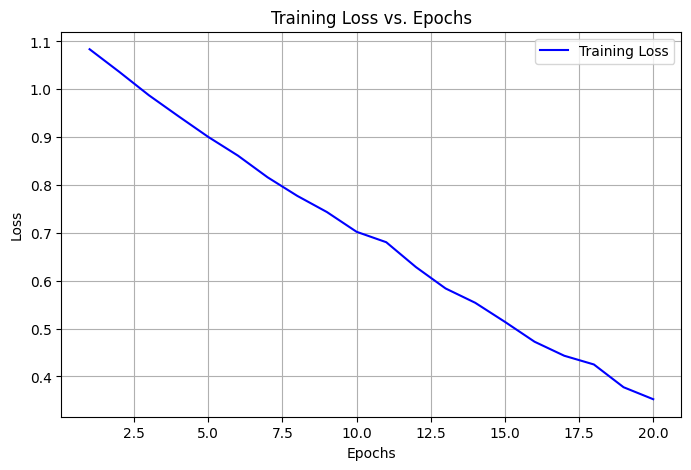

In [ ]:
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(epochs, train_losses, 'b-', label='Training Loss')  # 'b-' = blue solid line
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid lines
plt.show()

In [ ]:
model = Net().to(device)

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"--- Model Parameter Analysis ---")
print(f"Total Trainable Parameters: {total_params:,}") # The :, adds commas for readability
print("---------------------------------")

--- Model Parameter Analysis ---
Total Trainable Parameters: 109,115
---------------------------------


In [ ]:
print(f"--- Layer-by-Layer Parameter Breakdown ---")
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad:
        continue
    params = parameter.numel()
    print(f"{name:<40} | Shape: {str(list(parameter.shape)):<20} | Params: {params:,}")
    total_params += params

print("---------------------------------------------------------")
print(f"Total Trainable Parameters: {total_params:,}")

--- Layer-by-Layer Parameter Breakdown ---
conv_layers.0.weight                     | Shape: [32, 1, 3, 3]        | Params: 288
conv_layers.0.bias                       | Shape: [32]                 | Params: 32
conv_layers.1.weight                     | Shape: [64, 32, 3, 3]       | Params: 18,432
conv_layers.1.bias                       | Shape: [64]                 | Params: 64
conv_layers.2.weight                     | Shape: [128, 64, 3, 3]      | Params: 73,728
conv_layers.2.bias                       | Shape: [128]                | Params: 128
fc4.weight                               | Shape: [8, 2048]            | Params: 16,384
fc4.bias                                 | Shape: [8]                  | Params: 8
fc5.weight                               | Shape: [3, 16]              | Params: 48
fc5.bias                                 | Shape: [3]                  | Params: 3
---------------------------------------------------------
Total Trainable Parameters: 109,115


for  any config, training loss vs epochs is straight line

Part 15:

Hyper parameter tuning:

1. finding best lr keeping others fixed.

results:
gray scale
1. LR: 0.01 => Tr: 37.88, V:37.09, Te:33.81
2. LR: 0.001 => Tr: 87.97, V: 81.24, Te: 82.49
3. LR: 0.0001 => Tr:49.07 , V:48.20 , Te: 49.16

32,64,128 => tr:96.39, valid: 87.3, test:83.3

16,32,64 => test: 82.49

16,32 => tr: 88.47, v: 82.4, t: 78.42

Notice that the training accuracy (96.39%) is much higher than the validation/test accuracy (~85%). This gap indicates that the model is starting to overfit, which is very normal for a more powerful network. It's "memorizing" the training data a bit too well. We can address this with regularization techniques later.

Now with weight decay and dropout,

**hard-coded results**

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Your confusion matrix
# cm = np.array([
#     [361,   0,   0,   1,   0,   0],
#     [  3, 259,   4,  10,   2,   9],
#     [  0,   2, 631,   3,   4,   0],
#     [  0,   0,   0, 732,  19,   2],
#     [  0,   0,   0,   3, 810,   3],
#     [  0,   2,   0,  10,   3, 494]
# ])

# # Class labels
# classes =  ["Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# # Create the plot
# plt.figure(figsize=(10, 8))
# ax = sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=classes,
#     yticklabels=classes,
#     linewidths=0.5,      # Add borders between cells
#     linecolor='black',   # Border color
#     cbar=True          # Remove color bar for simplicity (optional)
# )

# # Enhance readability
# ax.set_title("Confusion Matrix of Training Dataset", fontsize=14)
# ax.set_xlabel("Predicted Label", fontsize=12)
# ax.set_ylabel("True Label", fontsize=12)

# # Save and show
# plt.savefig("confusion_matrix_boxed.png", dpi=300, bbox_inches="tight")
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Your confusion matrix
# cm = np.array([
#     # Predicted: Bronchiectasis, Bronchiolitis, COPD, Healthy, Pneumonia, URTI
#     [82,   0,   0,   0,   0,   0],   # True: Bronchiectasis
#     [ 5,  57,   1,   4,   1,  12],   # True: Bronchiolitis
#     [ 0,   1, 150,   1,   0,   0],   # True: COPD
#     [ 0,   0,   3, 177,   3,   1],   # True: Healthy
#     [ 0,   0,   1,   0, 185,   1],   # True: Pneumonia
#     [ 0,   0,   0,   0,   1, 121]    # True: URTI
# ])

# # Class labels
# classes =  ["Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# # Create the plot
# plt.figure(figsize=(10, 8))
# ax = sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=classes,
#     yticklabels=classes,
#     linewidths=0.5,      # Add borders between cells
#     linecolor='black',   # Border color
#     cbar=True          # Remove color bar for simplicity (optional)
# )

# # Enhance readability
# ax.set_title("Confusion Matrix of Testing Dataset", fontsize=14)
# ax.set_xlabel("Predicted Label", fontsize=12)
# ax.set_ylabel("True Label", fontsize=12)

# # Save and show
# plt.savefig("confusion_matrix_boxed.png", dpi=300, bbox_inches="tight")
# plt.show()

In [ ]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# from tabulate import tabulate

# # Your confusion matrix
# cm = np.array([
#     [361,   0,   0,   1,   0,   0],
#     [  3, 259,   4,  10,   2,   9],
#     [  0,   2, 631,   3,   4,   0],
#     [  0,   0,   0, 732,  19,   2],
#     [  0,   0,   0,   3, 810,   3],
#     [  0,   2,   0,  10,   3, 494]
# ])

# # Generate labels
# y_true, y_pred = [], []
# for i in range(len(cm)):
#     for j in range(len(cm[i])):
#         y_true.extend([i] * cm[i][j])
#         y_pred.extend([j] * cm[i][j])

# # Calculate metrics
# metrics = {
#     "Accuracy": [accuracy_score(y_true, y_pred)],
#     "Weighted Precision": [precision_score(y_true, y_pred, average='weighted')],
#     "Weighted Recall": [recall_score(y_true, y_pred, average='weighted')],
#     "Weighted F1": [f1_score(y_true, y_pred, average='weighted')]
# }

# # Per-class metrics
# classes = ["Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# precision_per = precision_score(y_true, y_pred, average=None)
# recall_per = recall_score(y_true, y_pred, average=None)
# f1_per = f1_score(y_true, y_pred, average=None)

# # Create tables
# print("OVERALL METRICS")
# print(tabulate([[k, f"{v[0]:.4f}"] for k,v in metrics.items()],
#                headers=["Metric", "Value"], tablefmt="grid"))

# print("\nPER-CLASS METRICS")
# per_class_data = []
# for i, cls in enumerate(classes):
#     per_class_data.append([
#         cls,
#         f"{precision_per[i]:.4f}",
#         f"{recall_per[i]:.4f}",
#         f"{f1_per[i]:.4f}"
#     ])
# print(tabulate(per_class_data,
#                headers=["Class", "Precision", "Recall", "F1-Score"],
#                tablefmt="grid"))

In [ ]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# from tabulate import tabulate

# # Your confusion matrix
# cm = np.array([
#     # Predicted: Bronchiectasis, Bronchiolitis, COPD, Healthy, Pneumonia, URTI
#     [82,   0,   0,   0,   0,   0],   # True: Bronchiectasis
#     [ 5,  57,   1,   4,   1,  12],   # True: Bronchiolitis
#     [ 0,   1, 150,   1,   0,   0],   # True: COPD
#     [ 0,   0,   3, 177,   3,   1],   # True: Healthy
#     [ 0,   0,   1,   0, 185,   1],   # True: Pneumonia
#     [ 0,   0,   0,   0,   1, 121]    # True: URTI
# ])

# # Generate labels
# y_true, y_pred = [], []
# for i in range(len(cm)):
#     for j in range(len(cm[i])):
#         y_true.extend([i] * cm[i][j])
#         y_pred.extend([j] * cm[i][j])

# # Calculate metrics
# metrics = {
#     "Accuracy": [accuracy_score(y_true, y_pred)],
#     "Weighted Precision": [precision_score(y_true, y_pred, average='weighted')],
#     "Weighted Recall": [recall_score(y_true, y_pred, average='weighted')],
#     "Weighted F1": [f1_score(y_true, y_pred, average='weighted')]
# }

# # Per-class metrics
# classes = ["Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

# precision_per = precision_score(y_true, y_pred, average=None)
# recall_per = recall_score(y_true, y_pred, average=None)
# f1_per = f1_score(y_true, y_pred, average=None)

# # Create tables
# print("OVERALL METRICS")
# print(tabulate([[k, f"{v[0]:.4f}"] for k,v in metrics.items()],
#                headers=["Metric", "Value"], tablefmt="grid"))

# print("\nPER-CLASS METRICS")
# per_class_data = []
# for i, cls in enumerate(classes):
#     per_class_data.append([
#         cls,
#         f"{precision_per[i]:.4f}",
#         f"{recall_per[i]:.4f}",
#         f"{f1_per[i]:.4f}"
#     ])
# print(tabulate(per_class_data,
#                headers=["Class", "Precision", "Recall", "F1-Score"],
#                tablefmt="grid"))